In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def gaussianFilter(img, kernel_size=5, sigma=3):
    '''
    Write a program to implement gaussian filter. You have to assume square kernels.
    
    Inputs:
    + img - grayscaled image of size N x N
          - values between [0, 255] - 'uint8'
    + kernel_size - size of the kernel window which should be used for smoothing. 
    + sigma - sigma parameter for gaussian kernel
    
    Ouputs:
    + out_img - smoothed grayscaled image of size N x N
              - values between [0, 255] - 'uint8'
    
    Allowed modules:
    + Basic numpy operations
    + cv2.filter2D() to perform 2D convolution
    + cv2.getGaussianKernel(). Note that this will give you 1D gaussian.
    
    Hint:
    + Not needed.
    
    '''
    
    #############################
    # Start your code from here #
    #############################
    h,w = img.shape[:2]

    out_img = np.zeros((h, w), dtype=np.uint8)
    
    k = int((kernel_size-1)/2)
    
    kernel = np.ones((kernel_size, kernel_size))
    
    sigma_sq = 2*sigma*sigma
    
    sum_ker = 0
    
    for i in range(-k,k+1):                        
        for j in range (-k,k+1):
            d_sq = (i*i) + (j*j)
            kernel[i+k,j+k] = (1/(math.pi * sigma_sq)) * math.exp(-(d_sq/sigma_sq))
            sum_ker = sum_ker + kernel[i+k,j+k]
            
    
    kernel_norm = kernel/sum_ker       
            
    out_img = cv2.filter2D(img,-1,kernel_norm)

    #############################
    # End your code here ########
    #############################    
    
    return out_img

In [3]:
def detect_edge_canny(img, lt, ht):
  '''
  Write a program to detect egdes using the canny algorithm. Pseudo code is given
  for your help

  Inputs:
  - img     - np array of guassian filttered grayscale image
  - lt      - lower threshold for hysteresis linking
  - ht      - higher threshold for hysteresis linking

  Outputs:
  - img_edge  - np array of the image with edges

  Allowed modules:
  - Numpy, cv, math
  - you are not allowed to use cv2.Canny() or any other direct implementations

  '''

  #############################
  # Start your code from here #
  #############################
    
  # 1) Start with filtering the image with Sobel kernel both in x and y direction
  #    and store the images as Mx and My.

  h,w = img.shape[:2]  

  Kx = np.array ([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  
  
  Ky = np.array ([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

  Mx = cv2.filter2D(img,-1,Kx)
    
  My = cv2.filter2D(img,-1,Ky)
    
    
  # 2) Find the gradient magnitude M and angle theta for each pixel by formulas 
  #    explained in lecture. Also round off the angle to 0, 45, 90, 135 degrees.

  img_edge = np.zeros((h,w), dtype=np.uint8)
  
  theta = np.arctan2(My, Mx) * 180 / np.pi
    
  M = np.hypot(Mx, My)
  
    
  for i in range(h):
    for j in range(w):

        
        if(theta[i,j]<0):
            theta[i,j] = 180 + theta[i,j]
       
        if(22.5<=theta[i,j]<67.5):
            theta[i,j] = 45
            
        elif(67.5<=theta[i,j]<112.5):
            theta[i,j] = 90
            
        elif(112.5<=theta[i,j]<157.5):
            theta[i,j] = 135
            
        else:
            theta[i,j] = 0
        
  

    
  # 3) Non maximum Supression -
  #   3.1) Check if every pixel is local maximum in the gradient direction theta
  #   3.2) if it is maximum take that pixel as edge make the value 255 and assign
  #        zero to all other pixels in that direction. so that we get a single 
  #        pixel edge


  for i in range(1,h-1):
        for j in range(1,w-1):
            
            if(theta[i,j] == 45):
                if (M[i,j] >= M[i-1,j+1] and M[i,j] >= M[i+1,j-1]):
                    img_edge[i,j] = M[i,j]


                else:
                    img_edge[i,j] = 0
                    
            elif(theta[i,j] == 90):
                if (M[i,j] >= M[i-1,j] and M[i,j] >= M[i+1,j]):
                    img_edge[i,j] = M[i,j]


                else:
                    img_edge[i,j] = 0
                    
            elif(theta[i,j] == 135):
                if (M[i,j] >= M[i-1,j-1] and M[i,j] >= M[i+1,j+1]):
                    img_edge[i,j] = M[i,j]


                else:
                    img_edge[i,j] = 0
                    
            else:
                if (M[i,j] >= M[i,j-1] and M[i,j] >= M[i,j+1]):
                    img_edge[i,j] = M[i,j]

                else:
                    img_edge[i,j] = 0
                    


  # 4) Linking - 
  #    use the process of hysteresis linking explained in the lecture for discarding
  #    weak edges and selecting the strong edges using the threshold lt and ht
    
  d = h*w  
  strongEdgesRow = np.zeros((1,d))
  strongEdgesRow_new = np.zeros((1,d))
  strongEdgesCol = np.zeros((1,d))
  strongEdgesCol_new = np.zeros((1,d))
  weakEdgesRow = np.zeros((1,d))
  weakEdgesCol = np.zeros((1,d))
  strongIndex = 0
  strongIndex_new = 0
  weakIndex = 0
    
  for i in range (2,h-2):
    for j in range (2,w-2):
        
        if img_edge[i,j] >= ht:
            
            img_edge[i,j]=255
            strongEdgesRow[0,strongIndex] = i
            strongEdgesCol[0,strongIndex] = j
            strongIndex = strongIndex + 1
            
        elif(lt<=img_edge[i,j]<ht):
            img_edge[i,j]=128
            weakEdgesRow[0,weakIndex] = i
            weakEdgesCol[0,weakIndex] = j
            weakIndex = weakIndex + 1
            
        else:
            img_edge[i,j]=0
         
  while(strongIndex > 0):
    for i in range(strongIndex):
        for k in range(-1,2):
            for l in range(-1,2):
                i_n = int(strongEdgesRow[0,i] + k)
                j_n = int(strongEdgesCol[0,i] + l)
                if(img_edge[i_n,j_n] == 128):
                                    img_edge[i_n,j_n] = 255
                                    strongEdgesRow_new[0,strongIndex_new] = i_n
                                    strongEdgesCol_new[0,strongIndex_new] = j_n
                                    strongIndex_new = strongIndex_new + 1
    
    
                
    strongIndex = strongIndex_new
    strongEdgesRow = np.copy(strongEdgesRow_new)
    strongEdgesCol = np.copy(strongEdgesCol_new)
    strongIndex_new = 0
    strongEdgesRow_new = np.zeros((1,d))
    strongEdgesCol_new = np.zeros((1,d))
    
  for i in range(h):
    for j in range(w):
        if(img_edge[i,j] == 128):
            img_edge[i,j] = 0 

  #############################
  # End your code here ########
  #############################    
    
  return img_edge

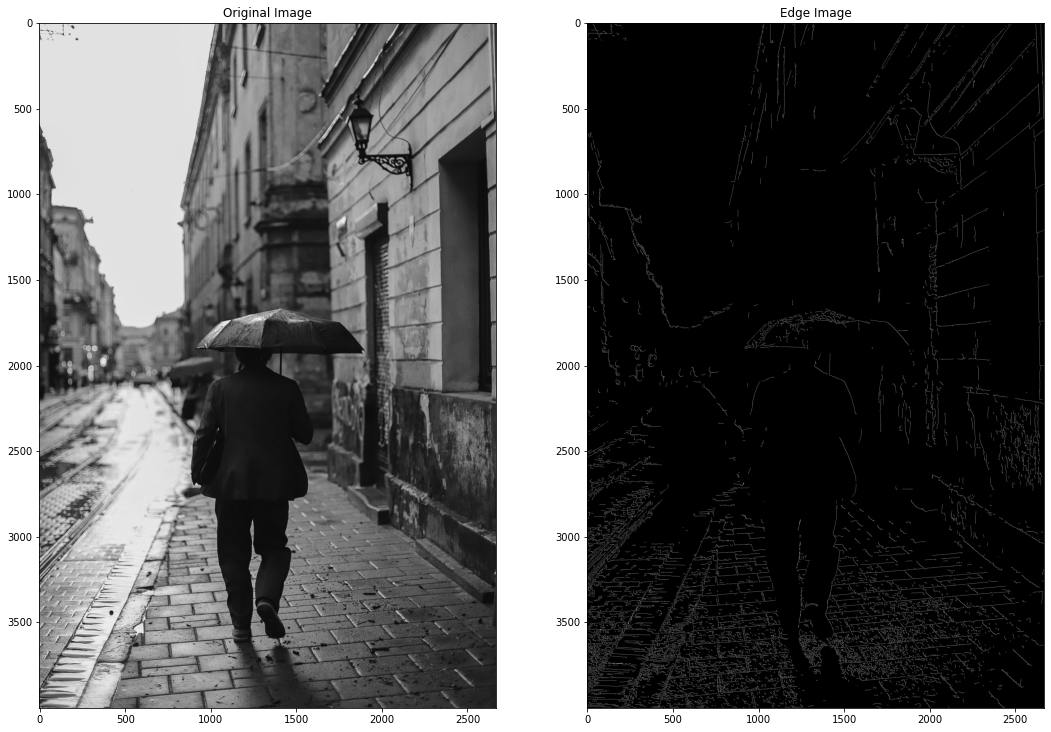

In [4]:
im = cv2.imread('im2.jpg')
im1 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im2 = gaussianFilter(im1, 5, 1.4)
im_edge = detect_edge_canny(im2, 30, 70)

plt.figure(figsize=(18, 18))


plt.subplot(121),plt.imshow(im1,cmap = 'gray')
plt.title('Original Image')
plt.subplot(122),plt.imshow(im_edge,cmap = 'gray')
plt.title('Edge Image')
plt.show()